## Title: Deep Hedging

### Luo, Tianpai
$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\newcommand{\Eof}[1]{\mathbb{E}\left[ #1 \right]}
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
\newcommand{\Pof}[1]{\mathbb{P}\left[ #1 \right]}
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\BS}{\text{BS}}
$$

### Abstract
We present and discuss the deep hedging problem in this project mostly based on the research contributed by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood. In the project, we introduce the theoretical framework of the deep hedging problem by Black-Scholes model and neural network. Besides theoretical discussion, we construct the program as proposed to analyze the performance of deep hedging under different situations such as different transaction cost from 0% to 5%. Simulated results show the efficiency of the deep hedging method. Furthermore, we apply the method on practical data S&P500 including stock price and index returns. The case of stock price indicates an unsatisfied results on loss and convergence, reasons might be the inappropriate use of historical volatility, defects of BS model itself. As for the case of index returns, we construct GJR-GARCH model to estimate volatility and then apply the deep hedging strategy. The deep hedging do have the effects of hedging, however, the neural network shows different results in the comparison of BS hedging, which is against the H.Bühlerr's comparisons. Reasons might be the large volatility change happened on S&P500 in 2020, whcih was later than the date of the paper's publishment. The structure and training settings may also be the factors affecting the comparison results.

*Keywords*: Deep learning, Neural network, Hedging, Transaction cost, Volatility, GJR-GARCH.


### Introduction
Based on the materials from lecture, deep hedging in a nutshell is to solve a stochastic control problem by the techniques introduced in reinforcement learning such as neural networks. There are many research works on deep hedging problem are listed in the lecture and we find works contributed by [Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood](https://arxiv.org/abs/1802.03042) are quite interesting and we choose to mainly review or discuss it in our final project. 

In our class and for previous risk management, only a few factors are modeled and we compute 'greeks' with respect to spot and calibration input such as implied volatilities even if they are not actually state variables. As a result, most models are low dimensional. This works under idealized frictionless and 'complete-market' assumption since , however, these assumptions do not exist in real market. All these models constructed on the complete-market condition place a lack of effecient alternatives even though progress were made in the last years such as robust hedging or super-hedging mentioned in [H.Bühler](https://arxiv.org/abs/1802.03042). 

However, the deep hedging approach can overcome this obstacle. The main idea is to parametrize the hedging strategies (at each time) via neural networks which can depend on input variables chosen by the user, for instance the current price, the past strategy, etc.
This then allows to solve a potentially high dimensional hedging problem for many assets whose dynamics are described by an arbitrary given arbitrage free model even in the presence of transaction costs. 
Besides, it also points out that the computational performance of deep hedging shows can maintain robustness when the size of portdolio changes. And that is the reason why we want to review and introduce deep hedging as our final project.

In deep hedging, several questions are investigated to illustrate the algorithm:
- The performance of deep hedging compared to the benchmark in a Heston model without transaction cost.
- The effect of proportional transaction costs on the exponential utility indifference price.
- The scalability of the numerical method scalable in higher dimensions.
- The performance in practice.

The following article will discuss the theoretical framework for pricing and hedging which is formulated by stochastic control problem, the solution of optimal hedging strategy from neural nets and numerical experiments or practical application for showing the feasibility and merits of deep hedging.

### Theoretical framework
Firstly, we introduce the Black-Scholes model. Assuming the price of the underlying asset follows the stochastic differential equation
$$
\frac{dS_t}{S_t} = \mu dt + \sigma dW_t,
$$
where
- $\mu$: (constant) expected return 
- $\sigma$: (constant) volatility 
- $W_t$: standard Brownian motion

For each time $t$, $S_t$ is lognormally distributed. More precisely,

$$
S_t \sim S_0 \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma \sqrt t Z \right]
$$

where $Z$ is a standard normal random variable.

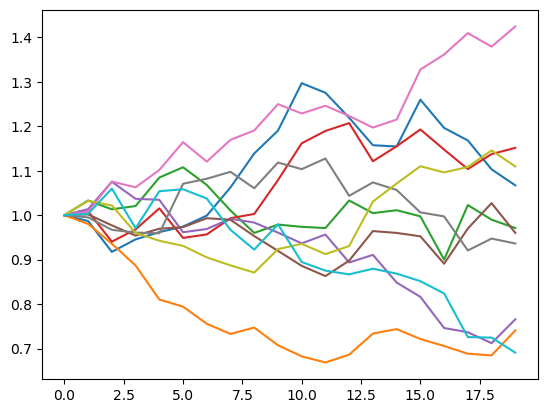

In [1]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards
import numpy as np
import matplotlib.pyplot as plt
N=20 # time disrectization
S0=1 # initial value of the asset
strike=1 # strike for the call option 
T=1.0 # maturity
sigma=0.2 # volatility in Black Scholes
R=10 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

for i in range(R):
   plt.plot(S[:,i])
plt.show()

Then we consider the problem of hedging $f(S_T)$. In the case of the Black Scholes model the hedging strategy can be found by the Delta hedge, i.e. 

$$
\Delta(t,s)=\partial_s \mathbb{E}[f(S_T)| S_t=s].
$$

In more involved models this is no longer possible. In particular in incomplete models not every claim can be hedged and we thus need to optimize a hedging criterion. We here consider a quadratic hedging criterion but other risk measures are of course also possible.

Let $\pi$ denote the price of the option, i.e. $\mathbb{E}[f(S_T)]$. Then the goal is to solve the following optimization problem 

$$
\inf_{H \text{ predictable }}\mathbb{E}[( f(S_T)- \pi- (H\bullet S)_T)^2],
$$

where $(H_t)$ ranges over all predictable process and $(H \bullet S)_T= \int_0^T H_t dS_t$ denotes the stochastic Ito integral. Optimizing over all predictable processes is infeasable. 

### Deep Learning

Recently, some impressive achievements in Artificial Intelligence have been achieved in areas like AI game playing, co mputer vision, nature language processing, etc. Some of these can even be in use in industry, rather than simply be studied in laboratory. 

Most progresses in AI recently apply a technique called **Deep Learning**, which is different from traditional machine learning in several aspects:

- Deep learning models take a long time to train.
- Deep learning models need a lot of data to train with.
- Deep learning algorithms can learn advanced features from data.

Thanks to the great improvement in computing power and the development in mathematical theory of neutral network, it is now possible for deep learning models to be trained and applied.

#### Neuron
Like our brain, neurons are the basic building blocks of neural networks. In a neural network, a neuron receives several inputs from the input of neural network or other neurons, and output the result after processing. The output result will be used as the input of the next neuron or as the final output.

A Neuron processes data in the follwing sequence:
- When information is passed into the neuron as input, the neuron will assign a relevant **weight** to each information, and then multiply the input information by the corresponding weight and add the products up. At the beginning, the neuron initializes the weight of each information, and then updates the weight of each information according to the corresponding feedback and model training.
- The neuron add a **bias** to the sum of the products. The bias is also updated according to the corresponding feedback and model training.
- Finally, the neuron apply a paticular **activation function** to the previous result to get the output.

The picture below describe a typical neuron datapath:

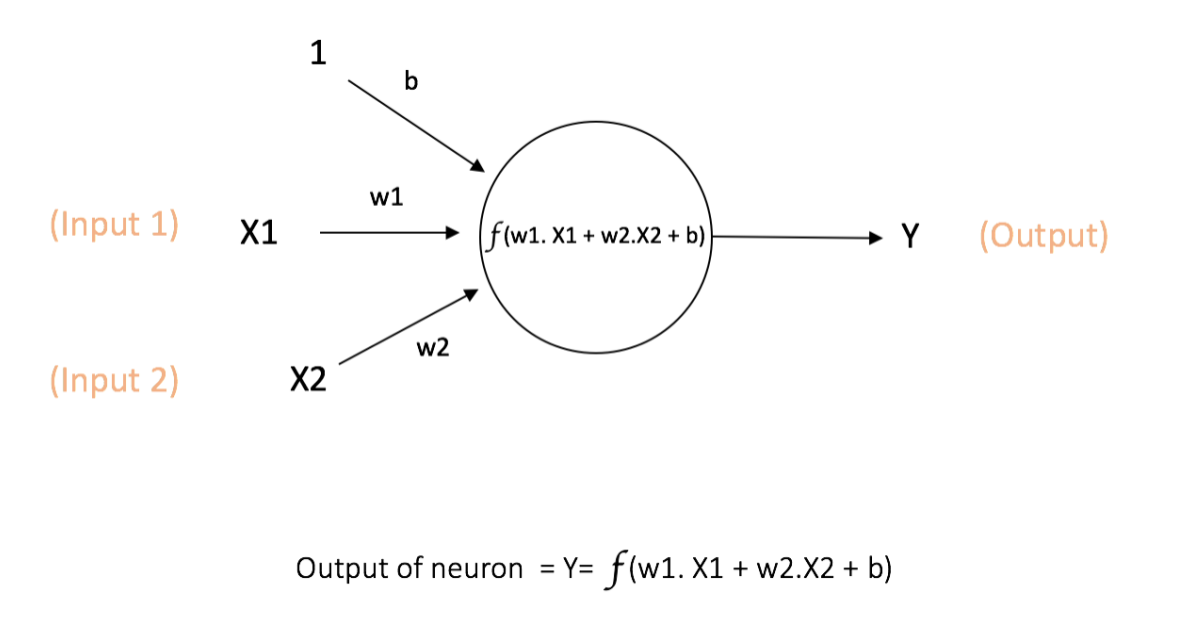

#### Layer
The picture below from *Buehler, Gonon, Teichmann, and Wood, Deep hedging* depicts a two-layer neural networks.
Several neurons from one layer, and several layers form a neural network.

Data flow from layer to layer.

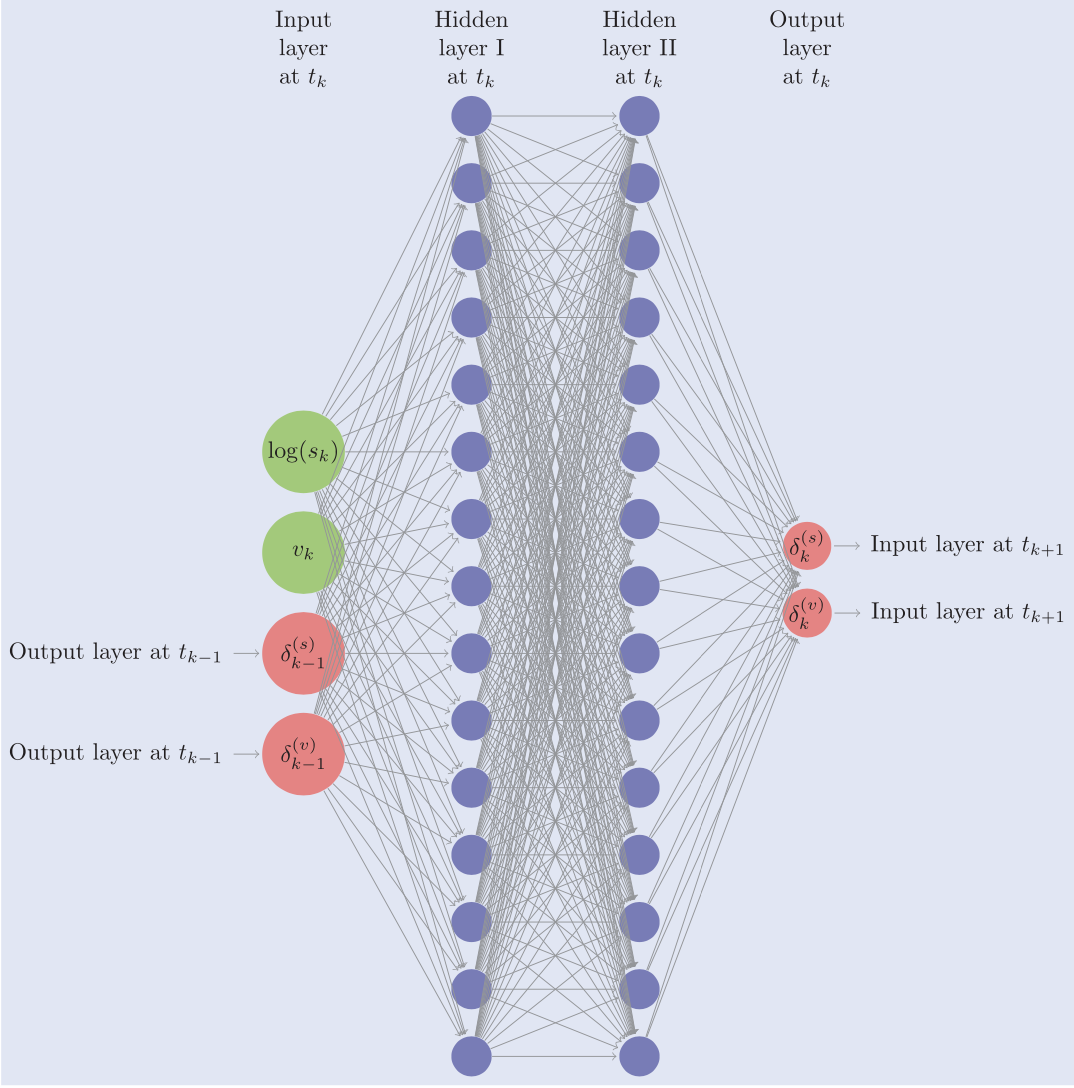

### Applying Deep Learning Methods to Hedging Problems

#### the Target Funtion for Deep Learning Model
Let's consider the portfolio value $V_t$. $i$ denotes the index of the assets.

Self-financing means that $V_{t+1}-V_t=\Sigma_{i=0}^{d}H_{t+1}^i(S_{t+1}^i-S_{t}^i)$.This means that the change in value of the portfolio comes from the change in value of the prices and nothing else.

Our final target is to let the sum of portfolio value, the cost for the option, the final payoff of the option and transaction costs(if exists) be as close to zero as possible.

#### Neuron Network Structure
Like the picture shown above, our neural network consists of N(time disrectization) times d(number of layers in strategy) number of layers. Each d layers take stock price and previous hedging decision as input, and output the new hedging decision.

#### Training data
We first generate data ouselves, and than try to apply the same methods on real data. Now we describe how to generate training data. 

Consider the drift part under BS model is $-\frac{\sigma^2}{2}$, and the random part is $\sigma$. Than $$dlog(S_t)=-\frac{\sigma^2}{2}dt + \sigma dW_t.$$ If we discretize our time interval, where total time to maturity is $T$ and step number is $N$, then $$log(S_i) = log(S_{i−1}) - -\frac{\sigma^2}{2}\frac{T}{N}+\sigma \sqrt{\frac{T}{N}}dZ_i,$$ where $Z_i$ are independent $N(0,1)$ distributed random variables. 

### Deep Learning without transaction cost

In [21]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from tensorflow.keras.layers import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

In [65]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 4352.34 strike 4352.34 maturity 1.0 and volatility 0.2509203063455683 is equal to 434.5408076210217


In [4]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]


In [5]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))

inputs = [price]+[hedge]


for j in range(N):
    strategy = price
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike) - priceBS)(price) 
outputs = Subtract()([payoff,hedge]) # payoff minus priceBS minus hedge

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

Instructions for updating:
Colocations handled automatically by placer.


The neural net trains strategy $j$ at time $j$ when we input the price at time $j$ simulated by Black-Scholes model. Therefore, each strategy $j$ is trained from different parameters mapping to the 2 layers we build. In this way massive parameters are involved in training a good hedging strategy respect to each input. The model summary below shows model totally has 1940 training parameters, and each parameter is actually a 'line' in our neural net model according to the graph we have showed.

In [6]:
model_hedge.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1)            0           lambda_1[0][0]                   
                                                                 input_3[0][0]                    
__________

In [7]:
Ktrain = 2*10**4
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1))

In [8]:
#sgd=optimizers.SGD(lr=0.0001)
#model_hedge.compile(optimizer=sgd,loss='mean_squared_error')
model_hedge.compile(optimizer='adam',loss='mean_squared_error')

In [9]:
for i in range(50):
    model_hedge.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
    #plt.hist(model_hedge.predict(xtrain))
    #plt.show()
    #print(np.mean(model_hedge.predict(xtrain)))

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
20000/20000 [==============================] - 4s 221us/step - loss: 0.0818
Epoch 1/1
20000/20000 [==============================] - 3s 146us/step - loss: 0.0037
Epoch 1/1
20000/20000 [==============================] - 3s 157us/step - loss: 0.0017
Epoch 1/1
20000/20000 [==============================] - 3s 152us/step - loss: 0.0011
Epoch 1/1
20000/20000 [==============================] - 3s 153us/step - loss: 7.7272e-04
Epoch 1/1
20000/20000 [==============================] - 3s 143us/step - loss: 6.6561e-04
Epoch 1/1
20000/20000 [==============================] - 3s 142us/step - loss: 6.5292e-04
Epoch 1/1
20000/20000 [==============================] - 3s 143us/step - loss: 6.5622e-04
Epoch 1/1
20000/20000 [==============================] - 3s 152us/step - loss: 6.6019e-04
Epoch 1/1
20000/20000 [==============================] - 3s 153us/step - loss: 6.7386e-04
Epoch 1/1
20000/20000 [==============================] - 3s 150us/st

From the training result, we can see the loss can decrease to a sufficiently low level (about $10^{-4}$) after a few literations, which shows the efficiency of the algorithm. Besides, the testing results show that the payoffs are all near to zero in 10000 simulations, which satisfies our requirement of hedging.

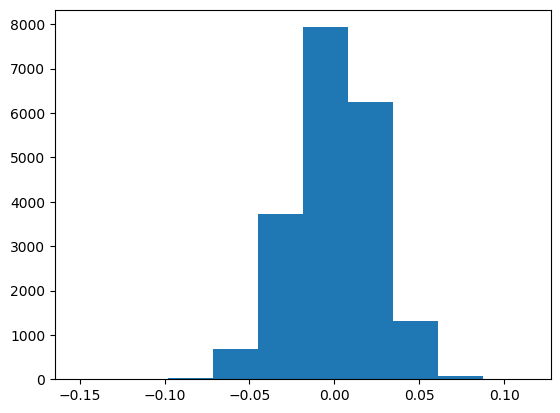

0.024263201
-3.2231106e-05


In [10]:
Ltest = 10**4
        
xtest=([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),(sigma)*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
plt.hist(model_hedge.predict(xtest))
plt.show()
print(np.std(model_hedge.predict(xtest)))
print(np.mean(model_hedge.predict(xtest)))

### Deep Hedging under transaction costs

In this part, we take transaction costs into consideration, which is propotion to the money paid in the transaction in our case. This only leads to minor changes in the final payoff fuction of the hedging problem.

We will first generate the stock price and call price the according to Black-Scholes Model to take a look at the . As before, we need to install tensorflow and keras to run the code below.

In [11]:
N=20 # time disrectization
S0=1 # initial value of the asset
strike=1 # strike for the call option 
T=1.0 # maturity
sigma=0.2 # volatility in Black Scholes
R=10 # number of Trajectories

transactionrate = 0.05

In [12]:
price = Input(shape=(m,))
hedge = Input(shape=(m,))
totalcosts = Input(shape=(1,))

inputs = [price]+[hedge]+[totalcosts]
transactionrate = 0.05
for j in range(N):
    strategy = price
    hedgehelper = hedge
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) 
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice) # creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew])
    inputs = inputs + [incr]
    price=pricenew
    # calculate the absolute changes of hedging and thus calculate the transaction costs
    change = Subtract()([hedge,hedgehelper])
    absolutechanges = Lambda(lambda x : K.abs(x))(change)
    costs = Lambda(lambda x : -transactionrate*K.sum(x,axis=1))(absolutechanges)
    totalcosts = Add()([totalcosts,costs])
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike) - priceBS)(price) 
outputs = Subtract()([payoff,hedge])
outputs = Add()([outputs,totalcosts])

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
Ktrain = 2*10**4
initialprice = S0

xtrain = ([initialprice*np.ones((Ktrain,m))] + # the price S0
          [np.zeros((Ktrain,m))]+ # the initial hedging being 0
          [np.zeros((Ktrain,1))]+ # the initial costs
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]) # the increments of the log price process 

ytrain=np.zeros((Ktrain,1))

In [14]:
adam=optimizers.Adam(lr=0.01)

model_hedge.compile(optimizer='adam',loss='mean_squared_error')

model_hedge.fit(x=xtrain,y=ytrain, epochs=50,verbose=True)

Epoch 1/50
20000/20000 [==============================] - 6s 281us/step - loss: 8.2455e-04
Epoch 2/50
20000/20000 [==============================] - 3s 175us/step - loss: 8.2058e-04
Epoch 3/50
20000/20000 [==============================] - 4s 184us/step - loss: 8.1620e-04
Epoch 4/50
20000/20000 [==============================] - 4s 182us/step - loss: 8.1272e-04
Epoch 5/50
20000/20000 [==============================] - 4s 176us/step - loss: 8.1842e-04
Epoch 6/50
20000/20000 [==============================] - 3s 175us/step - loss: 8.1446e-04
Epoch 7/50
20000/20000 [==============================] - 4s 177us/step - loss: 8.0778e-04
Epoch 8/50
20000/20000 [==============================] - 4s 178us/step - loss: 8.0476e-04
Epoch 9/50
20000/20000 [==============================] - 4s 178us/step - loss: 8.0872e-04
Epoch 10/50
20000/20000 [==============================] - 4s 177us/step - loss: 8.0590e-04
Epoch 11/50
20000/20000 [==============================] - 4s 178us/step - loss: 8.0958e-

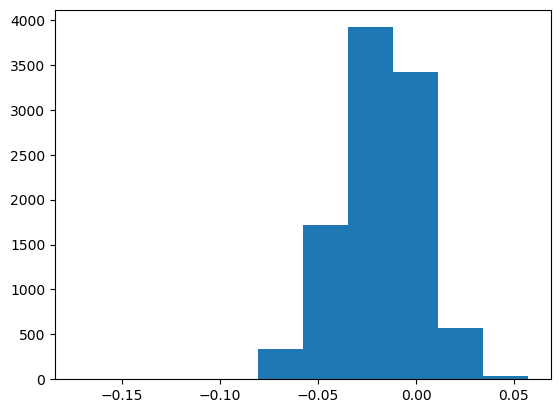

0.020451058
-0.018000858


In [16]:
Ltest = 10**4
        
xtest=([initialprice*np.ones((Ltest,m))] +
          [np.zeros((Ltest,m))]+
           [np.zeros((Ltest,1))]+
          [np.random.normal(-(sigma)**2*T/(2*N),(sigma)*np.sqrt(T)/np.sqrt(N),(Ltest,m)) for i in range(N)])
plt.hist(model_hedge.predict(xtest))
plt.show()
print(np.std(model_hedge.predict(xtest)))
print(np.mean(model_hedge.predict(xtest)))

The loss is slighterly greater than the situation without transaction cost, and a larger part of hedging leads to negative P&L, which is consistent with our intuitive.

We now take a look at how loss (the mean squared error of p&l) changes as transaction cost rate changes.

In [15]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = []
 
    def on_epoch_end(self, epoch,logs=None):
        self.losses.append(logs.get('loss'))

In [16]:
history = LossHistory()

for transactionrate in [x/200 for x in range(0, 10)]:
    layers = []
    for j in range(N):
        for i in range(d):
            if i < d-1:
                nodes = n
                layer = Dense(nodes, activation='tanh',trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
            else:
                nodes = m
                layer = Dense(nodes, activation='linear', trainable=True,
                              kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(i)+str(j))
            layers = layers + [layer]

    price = Input(shape=(m,))
    hedge = Input(shape=(m,))
    totalcosts = Input(shape=(1,))

    inputs = [price]+[hedge]+[totalcosts]

    for j in range(N):
        strategy = price
        hedgehelper = hedge
        for k in range(d):
            strategy= layers[k+(j)*d](strategy) 
        incr = Input(shape=(m,))
        logprice= Lambda(lambda x : K.log(x))(price)
        logprice = Add()([logprice, incr])
        pricenew=Lambda(lambda x : K.exp(x))(logprice) # creating the price at time j+1
        priceincr=Subtract()([pricenew, price])
        hedgenew = Multiply()([strategy, priceincr])
        #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
        hedge = Add()([hedge,hedgenew])
        inputs = inputs + [incr]
        price=pricenew
        # calculate the absolute changes of hedging and thus calculate the transaction costs
        change = Subtract()([hedge,hedgehelper])
        absolutechanges = Lambda(lambda x : K.abs(x))(change)
        costs = Lambda(lambda x : -transactionrate*K.sum(x,axis=1))(absolutechanges)
        totalcosts = Add()([totalcosts,costs])
    payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike) - priceBS)(price) 
    outputs = Subtract()([payoff,hedge])
    outputs = Add()([outputs,totalcosts])

    model_hedge = Model(inputs=inputs, outputs=outputs)
    Ktrain = 2*10**4
    initialprice = S0

    xtrain = ([initialprice*np.ones((Ktrain,m))] + # the price S0
              [np.zeros((Ktrain,m))]+ # the initial hedging being 0
              [np.zeros((Ktrain,1))]+ # the initial costs
              [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]) # the increments of the log price process 

    ytrain=np.zeros((Ktrain,1))
    model_hedge.compile(optimizer='adam',loss='mean_squared_error')

    model_hedge.fit(x=xtrain,y=ytrain, epochs=20,verbose=True,callbacks=[history])

Epoch 1/20
20000/20000 [==============================] - 6s 317us/step - loss: 0.0213
Epoch 2/20
20000/20000 [==============================] - 4s 180us/step - loss: 0.0010
Epoch 3/20
20000/20000 [==============================] - 4s 180us/step - loss: 7.4148e-04
Epoch 4/20
20000/20000 [==============================] - 4s 182us/step - loss: 6.9560e-04
Epoch 5/20
20000/20000 [==============================] - 4s 181us/step - loss: 6.8771e-04
Epoch 6/20
20000/20000 [==============================] - 4s 180us/step - loss: 6.7986e-04
Epoch 7/20
20000/20000 [==============================] - 4s 180us/step - loss: 6.7991e-04
Epoch 8/20
20000/20000 [==============================] - 4s 180us/step - loss: 6.7587e-04
Epoch 9/20
20000/20000 [==============================] - 4s 182us/step - loss: 6.7283e-04
Epoch 10/20
20000/20000 [==============================] - 4s 181us/step - loss: 6.7499e-04
Epoch 11/20
20000/20000 [==============================] - 4s 181us/step - loss: 6.6976e-04
Epoch

20000/20000 [==============================] - 10s 493us/step - loss: 0.1213
Epoch 2/20
20000/20000 [==============================] - 4s 209us/step - loss: 0.0041
Epoch 3/20
20000/20000 [==============================] - 4s 207us/step - loss: 0.0022
Epoch 4/20
20000/20000 [==============================] - 4s 208us/step - loss: 0.0015
Epoch 5/20
20000/20000 [==============================] - 4s 207us/step - loss: 0.0012
Epoch 6/20
20000/20000 [==============================] - 4s 213us/step - loss: 0.0011
Epoch 7/20
20000/20000 [==============================] - 4s 207us/step - loss: 9.8184e-04
Epoch 8/20
20000/20000 [==============================] - 4s 207us/step - loss: 9.1631e-04
Epoch 9/20
20000/20000 [==============================] - 4s 210us/step - loss: 8.9844e-04
Epoch 10/20
20000/20000 [==============================] - 4s 208us/step - loss: 8.8716e-04
Epoch 11/20
20000/20000 [==============================] - 4s 208us/step - loss: 8.8214e-04
Epoch 12/20
20000/20000 [======

[0.0006749876672402024, 0.0006306287749670446, 0.0006670251743169501, 0.0006481983351986855, 0.000698051716433838, 0.0007527028134092688, 0.0007543402219191194, 0.000756756507512182, 0.0008411146825179458, 0.0008871599827893078]


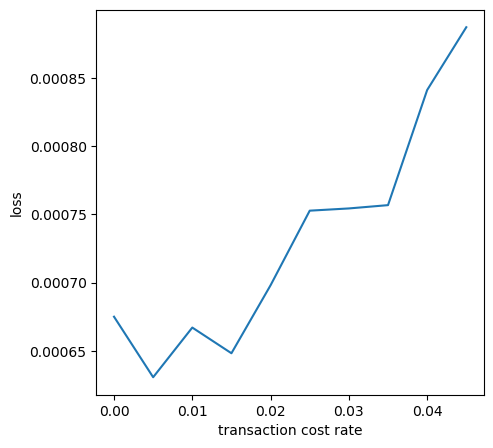

In [17]:
losses = history.losses[9::20]
print(losses)
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([x/200 for x in range(0, 10)],losses)
plt.xlabel("transaction cost rate", fontdict={'size': 10})
plt.ylabel("loss", fontdict={'size': 10})
plt.show()

Since we only run 20 epochs to train the model, the loss is higher and more volatile than previous results.

Consistent with our intuition, mean squared error of p&l goes upward as transaction cost rate grows.

### Deep Hedging under Real Data
#### Acquiring Real Data
First, we take a look at how to acquire real stock price data and the process we generate training and testing data from it.

The following code needs package **pandas** and **pandas_datareader**, one can easily run it but it takes time and may lead to different results.

In [18]:
# get trading code for stocks in S&P500
def LoadFile(filePath):
    code = []
    with open (filePath, 'r+') as fr:
        lines = fr.readlines()
        for line in lines:
            items = line.strip().split(' ')
            code.append(items[1])
    return code

codeSP500 = LoadFile("S&P500code.txt")
# print(codeSP500)

In [19]:
# this part may take considerable time
"""
# get historical stock pprice
import datetime
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as pdr
from  pandas import Series, DataFrame

start = datetime.datetime(2018, 1, 1)
end = datetime.date.today()
tickers = codeSP500

all_data = {}
error_tickers = []
for ticker in tickers:
    try:
        all_data[ticker] = pdr.get_data_yahoo(ticker, start, end)
    except:
        error_tickers.append(ticker)
"""

'\n# get historical stock pprice\nimport datetime\nimport pandas as pd\npd.core.common.is_list_like = pd.api.types.is_list_like\nimport pandas_datareader.data as pdr\nfrom  pandas import Series, DataFrame\n\nstart = datetime.datetime(2018, 1, 1)\nend = datetime.date.today()\ntickers = codeSP500\n\nall_data = {}\nerror_tickers = []\nfor ticker in tickers:\n    try:\n        all_data[ticker] = pdr.get_data_yahoo(ticker, start, end)\n    except:\n        error_tickers.append(ticker)\n'

In [21]:
# dump this into pickle file
import pickle as pkl
"""
with open ("stockSP500", 'wb') as f:
    pkl.dump(all_data, f)
"""
# load data from pickle file
with open ("stockSP500", 'rb') as f: 
    stockSP500 = pkl.load(f) 
    print(stockSP500)

{'A':                   High         Low        Open       Close     Volume  \
Date                                                                    
2018-01-02   67.889999   67.339996   67.419998   67.599998  1047800.0   
2018-01-03   69.489998   67.599998   67.620003   69.320000  1698900.0   
2018-01-04   69.820000   68.779999   69.540001   68.800003  2230700.0   
2018-01-05   70.099998   68.730003   68.730003   69.900002  1632500.0   
2018-01-08   70.330002   69.550003   69.730003   70.050003  1613400.0   
...                ...         ...         ...         ...        ...   
2021-08-06  155.889999  154.470001  154.759995  155.699997  1209300.0   
2021-08-09  156.800003  155.009995  156.080002  156.539993   982900.0   
2021-08-10  157.600006  155.899994  156.919998  156.520004  1575900.0   
2021-08-11  156.990005  155.850006  156.690002  156.520004  1402500.0   
2021-08-12  157.919998  156.125000  156.509995  157.500000   277084.0   

             Adj Close  
Date               

We can't find access to historical option trading data, option data from package such as *yfinanace* only lists options haven't reached maturity and their last trading data. So we generate the option price from BS module according to 7-day historical volatility. 

One can run the following code, but we have prepared train & test data in this way already.

In [22]:
#Blackscholes price
N=20 # time disrectization
S0=1 # initial value of the asset
T=N/252 # maturity

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

In [23]:
"""
# delete stock data which doesn't last long enough
# caluclate 7-day historical volatility
short=[]
for key in stockSP500.keys():
    if (len(stockSP500[key])<2*N+2):
        short.append(key)
    else:
        stockSP500[key]["7d_vol"] = stockSP500[key]["Adj Close"].rolling(7).std()
        
for key in short:
    stockSP500.pop(key)

# generate training data
strike = np.random.rand(Ktrain,1)
xtrain_new = ([initialprice*np.ones((Ktrain,1))] +
          [np.zeros((Ktrain,1))]+
          [strike] + 
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,1)) for i in range(N)])

ytrain_new = np.zeros((Ktrain,1))
listst = list(stockSP500)
logpriceincr = np.zeros((Ktrain,N))

# randomly pick 20-days price data sequence and calulate log price increase
for i in range(Ktrain):
    key = np.random.choice(listst)
    stockprice = stockSP500[key]
    date_idx = np.random.randint(len(stockprice)-N*2-1)
    price = np.array(stockprice["Adj Close"][N+date_idx-1:2*N+date_idx])
    price[price<1e-4]=1e-4 # avoid nan due to log calulation
    logprice = np.log(price)
    logpriceincrnew = np.diff(logprice)
    if stockprice["7d_vol"][N+date_idx-1] < 1e-4: # avoid nan due to division
        ytrain_new[i][0] = BS(S0, strike[i], T, 1e-4) 
    else:
        ytrain_new[i][0] = BS(S0, strike[i], T, stockprice["7d_vol"][N+date_idx-1]) # generate option price
    logpriceincr[i]=logpriceincrnew
    # logpriceincr[i]=price[0:-1]

logpriceincr_tmp = []
for i in range(N):
    logpriceincr_tmp.append(logpriceincr[:,i].reshape(Ktrain,1))
logpriceincr = logpriceincr_tmp

for i in range(N):
    xtrain_new[i+3]=logpriceincr[i]
#print(xtrain_new)
#print(ytrain_new)

Ktest = 10**3
strikestest = np.random.rand(Ktest,1)
xtest_new = ([initialprice*np.ones((Ktest,1))] +
          [np.zeros((Ktest,1))]+
          [strikestest] + 
          #[np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,1)) for i in range(N)])
         [np.zeros((Ktrain,1)) for i in range(N)])

ytest_new=np.zeros((Ktest,1))
#ytest=BS(S0, strikestest, T, sigma)
logpriceincr = np.zeros((Ktest,N))
for i in range(Ktest):
    key = np.random.choice(listst)
    stockprice = stockSP500[key]
    date_idx = np.random.randint(len(stockprice)-N*2-1)
    price = np.array(stockprice["Adj Close"][N+date_idx-1:2*N+date_idx])
    price[price<1e-4]=1e-4
    logprice = np.log(price)
    logpriceincrnew = np.diff(logprice)
    if stockprice["7d_vol"][N+date_idx-1] < 1e-4:
        ytest_new[i][0] = BS(S0, strikestest[i], T, 1e-4)
    else:
        ytest_new[i][0] = BS(S0, strikestest[i], T, stockprice["7d_vol"][N+date_idx-1])
    logpriceincr[i]=logpriceincrnew
    # logpriceincr[i]=price[0:-1]

logpriceincr_tmp = []
for i in range(N):
    logpriceincr_tmp.append(logpriceincr[:,i].reshape(Ktest,1))
logpriceincr = logpriceincr_tmp

for i in range(N):
    xtest_new[i+3]=logpriceincr[i]
#print(xtest_new)
#print(ytest_new)
"""

In [37]:
with open ("train&test", 'rb') as f:
    [xtrain,ytrain,xtest,ytest]=pkl.load(f)

In [38]:
d = 2 # number of layers in strategy
n = 32  # nodes in the first but last layers
N=20 # time disrectization

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = 1
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [39]:
price = Input(shape=(1,))
hedge = Input(shape=(1,))
strike = Input(shape=(1,))

inputs = [price]+[hedge]+[strike]


for j in range(N):
    strategy = Concatenate(axis=1)([price, strike])
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
    incr = Input(shape=(1,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) # payoff minus priceBS minus hedge

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

In [40]:
model_hedge.compile(optimizer='adam',loss='mean_squared_error')

In [41]:
model_hedge.fit(x=xtrain,y=ytrain,batch_size=128,epochs=30,verbose=True)

Epoch 1/30
10000/10000 [==============================] - 3s 298us/step - loss: 23.8338
Epoch 2/30
10000/10000 [==============================] - 0s 42us/step - loss: 17.0763
Epoch 3/30
10000/10000 [==============================] - 0s 42us/step - loss: 11.6515
Epoch 4/30
10000/10000 [==============================] - 0s 42us/step - loss: 7.3346
Epoch 5/30
10000/10000 [==============================] - 0s 42us/step - loss: 4.1707
Epoch 6/30
10000/10000 [==============================] - 0s 41us/step - loss: 2.3778
Epoch 7/30
10000/10000 [==============================] - 0s 42us/step - loss: 1.3663
Epoch 8/30
10000/10000 [==============================] - 0s 42us/step - loss: 0.7658
Epoch 9/30
10000/10000 [==============================] - 0s 41us/step - loss: 0.4202
Epoch 10/30
10000/10000 [==============================] - 0s 42us/step - loss: 0.2552
Epoch 11/30
10000/10000 [==============================] - 0s 42us/step - loss: 0.1655
Epoch 12/30
10000/10000 [=======================

In [30]:
loss_and_metrics = model_hedge.evaluate(xtest, ytest, batch_size=128)
print(loss_and_metrics)

1000/1000 [==============================] - 0s 460us/step
0.08290786337852478


The loss is quite large compared with previous results. Sometimes, the loss even can't converge to a relative small number.

This may due to following reasons:
- 7-days historical volatility fluctuates a lot.
- Historical volatility is quite different from implied volatility, which is more related to option prices.
- defects in BS model
- Real stock prices are impacted by dividend and splits, but we haven't cleaned data to remove their influences.

#### S&P500 index

In this part, we try to consider the problem of hedging an at-the-money European call option on the S&P500 index with time-to-maturity $T_{days}=30$ . Based on H.Buehler's method, we download the historical daily returns of the S&P500 index from 15 August 2016 to 13 August 2021. Then we split into a training period and a test period.

In [31]:
# read S&P500 daily data
import pandas as pd
import numpy as np
df = pd.read_csv('.\SP500_daily.csv',names=['Date','Index'],header=0)
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
SP500 = df['Index']
SP_train = SP500[:-30:]
SP_test = SP500[-30:]
SP500

Date
2016-08-15    2190.15
2016-08-16    2178.15
2016-08-17    2182.22
2016-08-18    2187.02
2016-08-19    2183.87
               ...   
2021-08-09    4432.35
2021-08-10    4436.75
2021-08-11    4447.70
2021-08-12    4460.83
2021-08-13    4468.00
Name: Index, Length: 1259, dtype: float64

To derive essential parameters for hedging such as $\sigma$, we construct a commonly used , well-established econometric modelfor fitting the training period. Here we pick GJR-GARCH model which is also used in H.Buehler's. According to research (Laurent et al. and Brownlees et al.) the GJR models generally perform better than the GARCH specification. Thus, including a leverage effect leads to enhanced forecasting performance.

$$
\begin{aligned}
\log \left(S_{k} / S_{k-1}\right) &=\mu+\varepsilon_{k}, \\
\varepsilon_{k} &=\sigma_{k} z_{k}, \\
\sigma_{k}^{2} &=\omega+\alpha \varepsilon_{k-1}^{2}+\beta \sigma_{k-1}^{2}+\gamma \varepsilon_{k-1}^{2} 1_{\left\{\varepsilon_{k-1}<0\right\}}.
\end{aligned}
$$

where $k\in\{-n_{ret}+T_{days},\dots,T_{days}\}$, $n_{ret}=1259$ and $k=0$ corresponds to the last period in the training period('today'). 

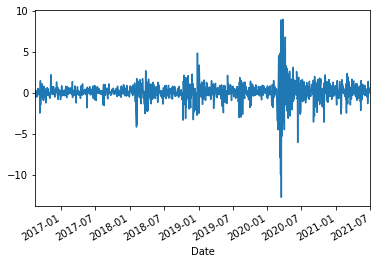

In [36]:
train_garch = 100 * np.log(SP_train).diff().dropna()
ax = train_garch.plot()
xlim = ax.set_xlim(train_garch.index.min(), train_garch.index.max())

In [37]:
from arch import arch_model
am = arch_model(train_garch, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Index   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1461.36
Distribution:                  Normal   AIC:                           2932.73
Method:            Maximum Likelihood   BIC:                           2958.29
                                        No. Observations:                 1228
Date:                Sun, Aug 15 2021   Df Residuals:                     1223
Time:                        17:38:44   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0691  1.769e-02      3.905  9.440e-05 [3.440e-0

The results of GJR-GARCH model show that the coefficients are all sufficient and the $\sigma_t$ is also estimated as volatility as below:

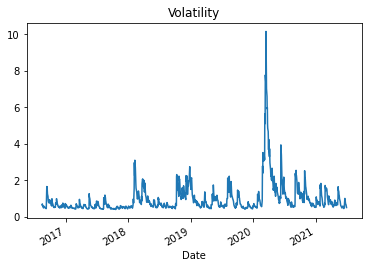

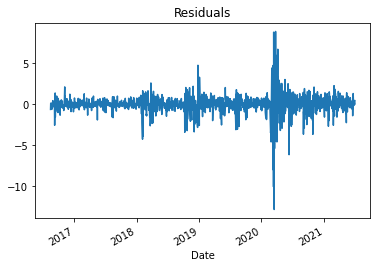

In [63]:
res.conditional_volatility.plot()
plt.title('Volatility')
plt.show()
res.resid.plot()
plt.title('Residuals')
plt.show()

In the graphs on volatility and residuals, we can see a tremendous inpulse after 2020, which is sufficiently different from the cases before. This may cause hedging results perform differently from the H.Buehler's paper proposed in 2019.

From the estimation of GJR-GARCH model, we can  we can derive $\hat\sigma_0$ which is also the beginning of our test date (2021-07-02) by formula:
$$
\begin{aligned}
\log \left(\hat S_{k} / \hat S_{k-1}\right) &=\hat\mu+\hat\varepsilon_{k}, \\
\hat\varepsilon_{k} &=\hat\sigma_{k} z_{k}, \\
\hat\sigma_{k}^{2} &=\hat\omega+\hat\alpha \hat\varepsilon_{k-1}^{2}+\hat\beta \hat\sigma_{k-1}^{2}+\hat\gamma \hat\varepsilon_{k-1}^{2} 1_{\left\{\hat\varepsilon_{k-1}<0\right\}},
\end{aligned}
$$
where

| $\hat\omega$ | $\hat\alpha$ | $\hat\beta$ |$\hat\gamma$ |
| --- | --- | --- | --- |
|0.0409|0.1323|0.7209| 0.2569 |

Then we can genereate sample paths from the estimation of GJR-GARCH model. And this sample paths can then be used to train the neurak network hedging strategy as in the previous simulation.

In [152]:
sigma = res.params[1]+res.params[2]*(res.resid[-1]**2) + res.params[4]*(res.conditional_volatility[-1]**2)+res.params[3]*(res.resid[-1]**2)*(res.resid[-1]<0)
sigma

0.2509203063455683

In [153]:
#Blackscholes price
N=30 # time disrectization
S0=np.log(SP_test[0]) # initial value of the asset
strike=S0 # strike for the call option 
T=1.0 # maturity

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))



Price of a Call option in the Black scholes model with initial price 8.37846891048418 strike 8.37846891048418 maturity 1.0 and volatility 0.2509203063455683 is equal to 0.8365124615699644


In [2]:
from IPython.display import clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from deep_hedging import Deep_Hedging_Model, Delta_SubModel
from loss_metrics import Entropy
from utilities import train_test_split

In [260]:
N = 30 # Number of time steps (in days)

S0 = np.log(SP_test[0]) # Stock price at time = 0
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed() # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1 # Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "proportional"

# Other control flags for development purpose.
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"

In [261]:
seed = 0 # Random seed. Change to have deterministic outcome.

# Total obs = Training + Testing
nobs = int(Ktrain*(1+Ktest_ratio)) 
		
# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt # Maturities (in the unit of a year)

stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

S = stochastic_process.gen_path(maturity, N, nobs)

clear_output()

print("\n\ns0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")



s0 = 8.37846891048418
sigma = 0.2509203063455683
risk_free = 0.0

Number of time steps = 30
Length of each time step = 1/365

Simulation Done!


In [262]:
payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set

if information_set is "S":
  I =  np.stack((S),axis=1) # Information set
elif information_set is "log_S":
  I =  np.stack((np.log(S)),axis=1)
elif information_set is "normalized_log_S":
  I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)
x_all = []
for i in range(N+1):
  x_all += [trade_set[i,:,None]]
  if i != N:
    x_all += [I[i,:,None]]
x_all += [payoff_T[:,None]]

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=test_size)

print("Finish preparing data!")

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-262-648b11a6810c>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
<ipython-input-262-648b11a6810c>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
<ipython-input-262-648b11a6810c>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


Finish preparing data!


In [263]:
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_simple = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=risk_free, \
          dt = dt, strategy_type="simple", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, delta_constraint = delta_constraint, \
          share_stretegy_across_time = share_stretegy_across_time, \
          cost_structure = cost_structure)
loss = Entropy(model_simple.output,None,loss_param)
model_simple.add_loss(loss)

model_simple.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_data=xtest, verbose=1)

clear_output()

print("Finished running deep hedging algorithm! (Simple Network)")

Finished running deep hedging algorithm! (Simple Network)


In [264]:
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
nn_simple_price = model_simple.evaluate(xtest, batch_size=test_size, verbose=0)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)


The Black-Scholes model price is 0.240.
The Risk Neutral price is 0.242.
The Deep Hedging (with simple network) price is 0.242.


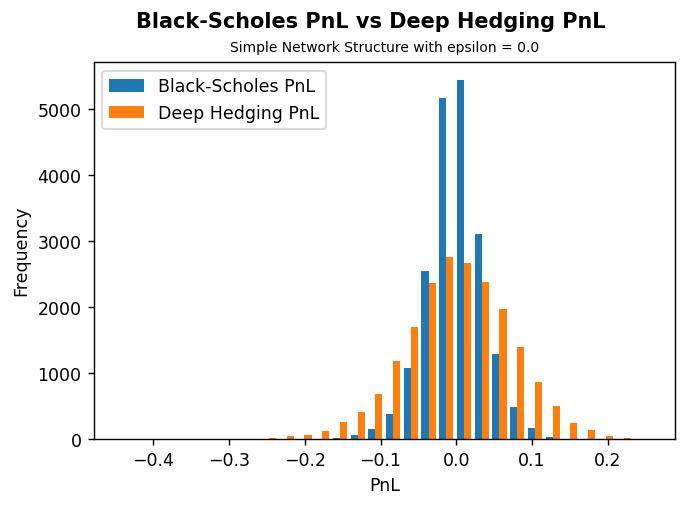

In [265]:
bar1 = PnL_BS + price_BS[0][0]
bar2 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

The results are different from the H.Buehler's paper, reasons may be:
- Votality : S&P500 changes since the big cliff on the voltality after 2020, which did not appear at the time of the paper.
- Model: Our deep learning model may be different from the paper such as the number of layers and nodes or some other subtlety. 
- Training set: We train a larger training set with the large votality after 2020 while the testing set dose not contain such large votality. 

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-266-c417ca48831a>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if information_set is "S":
<ipython-input-266-c417ca48831a>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "log_S":
<ipython-input-266-c417ca48831a>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif information_set is "normalized_log_S":


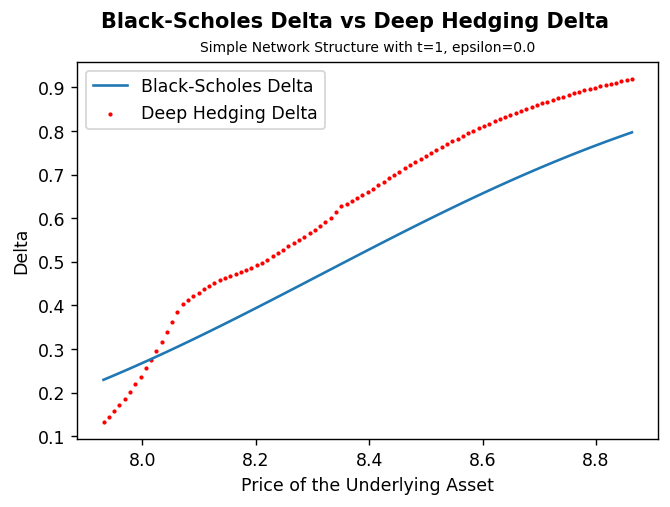

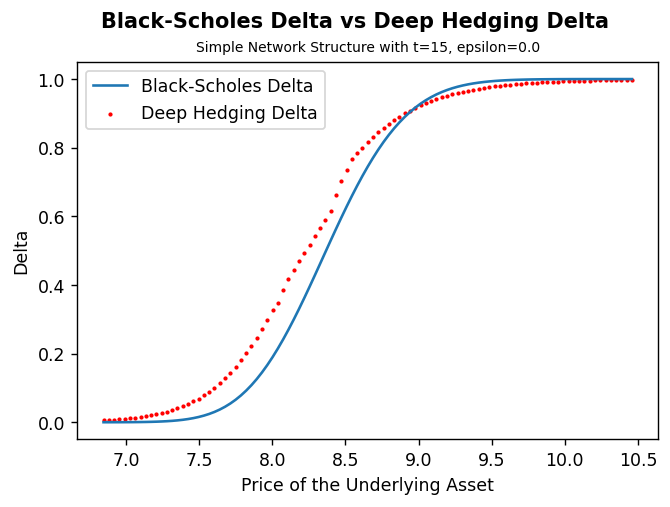

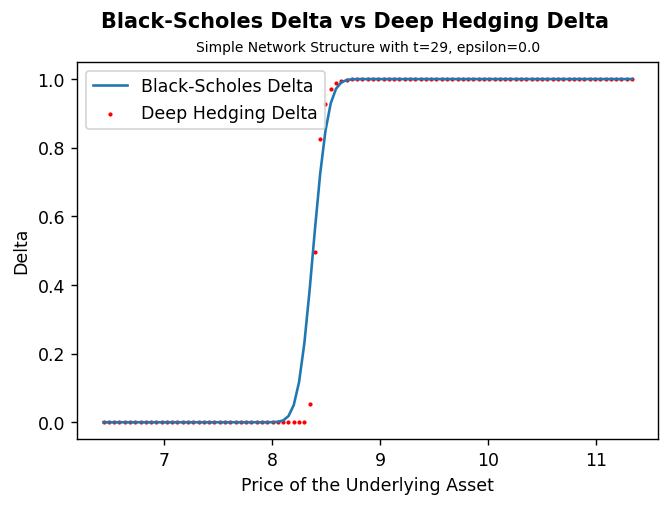

In [266]:
for days_from_today in (1,15,29):
  tau = (N-days_from_today)*dt
    
  min_S = S_test[0][:,days_from_today].min()
  max_S = S_test[0][:,days_from_today].max()
  S_range = np.linspace(min_S,max_S,101)

  # Attention: Need to transform it to be consistent with the information set.
  if information_set is "S":
    I_range =  S_range # Information set
  elif information_set is "log_S":
    I_range =  np.log(S_range)
  elif information_set is "normalized_log_S":
    I_range =  np.log(S_range/S0)        
      
  # Compute Black-Scholes delta for S_range.
  # Reference: https://en.wikipedia.org/wiki/Greeks_(finance)
  d1 = (np.log(S_range) - np.log(strike) + \
        (risk_free - dividend + (sigma**2)/2)*tau) \
              / (sigma*np.sqrt(tau))  
                
  model_delta = norm.cdf(d1)*np.exp(-dividend*tau)

  if share_stretegy_across_time is False:
    submodel = Delta_SubModel(model = model_simple, \
                      days_from_today = days_from_today)
  else:
    submodel = Delta_SubModel(model = model_simple, \
                      days_from_today = 0)
    
  nn_delta = submodel(I_range)

  # Create a plot of Black-Scholes delta against deep hedging delta.
  fig_delta = plt.figure(dpi= 125, facecolor='w')
  fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", \
        fontweight="bold")
  ax_delta = fig_delta.add_subplot()
  ax_delta.set_title("Simple Network Structure with " + \
              "t=" + str(days_from_today) + ", " + \
                "epsilon=" + str(epsilon), \
                fontsize=8)
  ax_delta.set_xlabel("Price of the Underlying Asset")
  ax_delta.set_ylabel("Delta")
  ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
  ax_delta.scatter(S_range,nn_delta, c="red", s=2, label="Deep Hedging Delta")
  ax_delta.legend()
  plt.show()

### Conclusion and discussions


- In our deep learning model the neural network consists of $N$(time disrectization) times d(number of layers in strategy) number of layers. Each $d$ layers take stock price and previous hedging decision as input, and output the new hedging decision. The target is to let the sum of portfolio value of hedging, the cost for the option, the final payoff of the option and transaction costs(if exists) be as close to zero as possible.


- At the case of hedging without transaction cost, the deep hedging strategy is well performed with almost 0 mean and pretty low standard deviation with low loss and high optimizing speed.


- By minus transaction costs from the previous target function, we can take a look at how this model behave under transaction costs. We consider the situation in which transaction costs are propotion to the money paid during the transaction. The train and test losses are of the same magnitude as those without transaction costs, though slightly larger, but more hedging strategies get a negative p&l than those without transaction costs. Also, the loss increases as transaction cost rate increases.


- After that, we apply the same model to real stock price and generated option price data. Since historical options trading data is difficult to acquire, we generat option price according to BS model from historical volatility. The  loss is around 10 precent, which is quite unsatisfactory. Sometimes the loss can't even converge. This may result from inappropriate use of historical volatility, defects of BS model itself.


- Applying the method to S&P500 index as proposed in H.Buehler's paper, results we derive are different from the paper. Reasons may be 3 aspects from our discussion. The most possible reason is that the votality of S&P500 is now sufficiently different from 2019 which is the time when the paper was published. Besides, the structure of deep learning model and characteristics of training-testing sets also cause the different results.  



### Reference
- [1] Hans Buhler et al, (2019). “Deep Hedging.” Quantitative Finance, 19(8).
- [2] Brownlees  CT,  Engle  RF,  Kelly  BT  (2011)  A practical  guide  to  volatility  forecasting  through calm and storm. Available at SSRN 1502915.
- [3] Laurent  S,  Rombouts  JV,  Violante  F  (2012)  On  the  forecasting  accuracy  of  multivariate  GARCH models. J Appl Econometrics 27: 934–955.
- [4] Risk.net, (2019). “Deep hedging and the end of the Black-Scholes era.”
- [5] https://github.com/YuMan-Tam/deep-hedging
